# Atlantic sector: DIC meriodional distribution

In [ ]:
# Not needed for B-SOSE

# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

import botocore  
import boto3
from boto3.session import Session

import s3fs

In [ ]:
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests

import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr

import numpy as np
import pandas as pd
import calendar
import gsw
#import warnings

In [ ]:
#warnings.filterwarnings("ignore")

In [ ]:
from dask.distributed import Client

#  connec to existing LocalCluster
# the port number will be different!
client = Client("tcp://127.0.0.1:42155")
client.ncores
client.restart()

In [15]:
# Plotting settings

plt.rcParams['figure.figsize'] = (10, 3)

In [2]:
# local path to monthly-mean MLD dataset
bsose_path = Path('/efs_ecco/alopicco/bsose_data/')

# make a list of all of the files in the directory
bsose_files = np.sort(list(bsose_path.glob('*nc')))

# show first 10 files
print('\nFirst 10 files')
pprint([x.name for x in bsose_files[:10]])


First 10 files
['ADVrDIC_bsoseI156_2013to2024_monthly.nc',
 'ADVr_SLT_bsoseI156_2013to2024_monthly.nc',
 'ADVr_TH_bsoseI156_2013to2024_monthly.nc',
 'DIC_bsoseI156_2013to2024_monthly.nc',
 'MLD_bsoseI156_2013to2024_monthly.nc',
 'Salt_bsoseI156_2013to2024_monthly.nc',
 'Theta_bsoseI156_2013to2024_monthly.nc',
 'WVELSLT_bsoseI156_2013to2024_monthly.nc',
 'WVELTH_bsoseI156_2013to2024_monthly.nc',
 'Wvel_bsoseI156_2013to2024_monthly.nc']


In [3]:
# local path to monthly-mean MLD dataset
bsose_path = Path('/efs_ecco/alopicco/bsose_data/')

# make a list of all of the files in the directory
bsose_files = np.sort(list(bsose_path.glob('*nc')))

# show first 5 files
print('\nFirst 5 files')
pprint([x.name for x in bsose_files[:5]])

# open dataset
MLD_file = bsose_path / 'MLD_bsoseI156_2013to2024_monthly.nc'
theta_file = bsose_path / 'Theta_bsoseI156_2013to2024_monthly.nc'
salt_file = bsose_path / 'Salt_bsoseI156_2013to2024_monthly.nc'
ADVrDIC_file = bsose_path / 'ADVrDIC_bsoseI156_2013to2024_monthly.nc'
DIC_file = bsose_path / 'DIC_bsoseI156_2013to2024_monthly.nc'
W_file = bsose_path / 'Wvel_bsoseI156_2013to2024_monthly.nc'
grid_file = bsose_path / 'grid.nc'


First 5 files
['ADVrDIC_bsoseI156_2013to2024_monthly.nc',
 'ADVr_SLT_bsoseI156_2013to2024_monthly.nc',
 'ADVr_TH_bsoseI156_2013to2024_monthly.nc',
 'DIC_bsoseI156_2013to2024_monthly.nc',
 'MLD_bsoseI156_2013to2024_monthly.nc']


In [4]:
# start timer
start_time = time.time()

# load the file into memory (note 'load' command at the end)
ds = xr.open_dataset(theta_file)
salt_ds = xr.open_dataset(salt_file)
ADVrDIC_ds = xr.open_dataset(ADVrDIC_file)
DIC_ds = xr.open_dataset(DIC_file)
MLD_ds = xr.open_dataset(MLD_file)
W_ds = xr.open_dataset(W_file)
grid_ds = xr.open_dataset(grid_file)

# stop timer
total_time = time.time() - start_time

print('\nloaded theta')
print(f'total time {total_time:.2f} sec')
print('time level : ' , ds.time.values[0])


loaded theta
total time 5.35 sec
time level :  2013-01-30T20:00:00.000000000


### ML temperature

In [5]:
theta_ML = np.full((ds.dims['time'],ds.dims['YC'],ds.dims['XC']),np.nan)
              
for ti in range(ds.dims['time']):
    MLD_t = MLD_ds.BLGMLD.isel(time=ti)
    theta_t = ds.THETA.isel(time=ti)
    theta_ML_t = np.mean(theta_t.where((-ds.Z<MLD_t)),axis=0)
    theta_ML[ti,:,:] = np.where(ds.maskInC,theta_ML_t,np.nan)

/tmp/ipykernel_1201/2097227020.py:1: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  theta_ML = np.full((ds.dims['time'],ds.dims['YC'],ds.dims['XC']),np.nan)
/tmp/ipykernel_1201/2097227020.py:3: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for ti in range(ds.dims['time']):


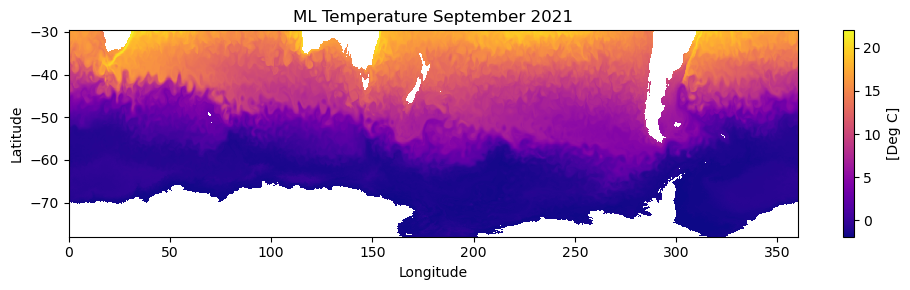

In [16]:
plt.figure()

#ti=97 # feb 2021
ti=104 # sept 2021
#var = theta_ML[ti,:,:]-SST[ti,:,:]
var = theta_ML[ti,:,:]

time_str = pd.to_datetime(ds.time[ti].values).strftime('%B %Y')

plt.pcolormesh(ds.XC, ds.YC, var, shading='auto', cmap='plasma')
plt.colorbar(label='[Deg C]')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'ML Temperature {time_str}')
plt.tight_layout()

plt.show()

### Gradients in ML temperature

In [7]:
# Find frontal regions for ML temperature

# Get x and y coordinate arrays
x = ds.XC  # shape (nx,)
y = ds.YC  # shape (ny,)

# Compute spacing
dx = np.gradient(x)  # shape (nx,)
dy = np.gradient(y)  # shape (ny,)

# Broadcast dx and dy to match SST shape
DX, DY = np.meshgrid(dx, dy)

# Compute SST gradient
dthetaML_dx = np.gradient(theta_ML, axis=2) / DX
dthetaML_dy = np.gradient(theta_ML, axis=1) / DY

# Gradient magnitude
grad_thetaML = np.sqrt(dthetaML_dx**2 + dthetaML_dy**2)

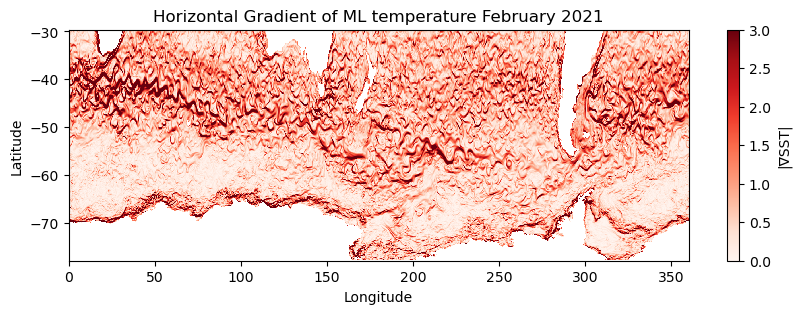

In [17]:
XCc, YCc = np.meshgrid(x, y)

plt.figure()

ti=97 # feb 2021
#ti=104 # sept 2021
time_str = pd.to_datetime(ds.time[ti].values).strftime('%B %Y')

var = grad_thetaML[ti,:,:]
#var = grad_thetaML[ti,:,:]-grad_SST[ti,:,:]

vmin = 0
vmax = 3
plt.pcolormesh(XCc, YCc, var, shading='auto', vmin=vmin, vmax=vmax, cmap='Reds')
plt.colorbar(label='|∇SST|')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Horizontal Gradient of ML temperature {time_str}')

plt.show()

### ML temperature gradient climatology

In [9]:
# Wrap gradient array into DataArray
grad_thetaML_da = xr.DataArray(
    grad_thetaML,
    coords={"time": ds.time, "YC": ds.YC, "XC": ds.XC},
    dims=["time", "YC", "XC"]
)

# Group by month and compute climatology (mean for each month)
grad_thetaML_clim = grad_thetaML_da.groupby("time.month").mean("time")

# Replace numeric months (1-12) with abbreviated names ('Jan', 'Feb', ...)
month_names = [calendar.month_abbr[m] for m in grad_thetaML_clim["month"].values]
grad_thetaML_clim = grad_thetaML_clim.assign_coords(month=("month", month_names))

### Winter and summer climatology of ML temperature gradient 

In [10]:
# Winter months: JAS
# Summer months: DJF

grad_thetaML_winter = grad_thetaML_clim.sel(month=["Jul", "Aug", "Sep"]).mean(dim='month')
grad_thetaML_summer = grad_thetaML_clim.sel(month=["Dec", "Jan", "Feb"]).mean(dim='month')

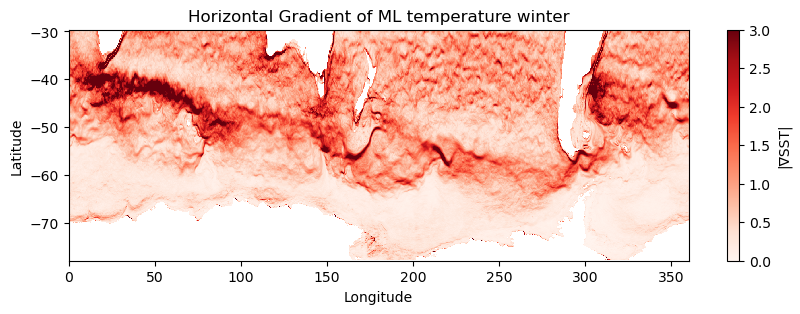

In [18]:
plt.figure()

time_str = pd.to_datetime(ds.time[ti].values).strftime('%B %Y')

var = grad_thetaML_winter

vmin = 0
vmax = 3
plt.pcolormesh(XCc, YCc, var, shading='auto', vmin=vmin, vmax=vmax, cmap='Reds')
plt.colorbar(label='|∇SST|')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Horizontal Gradient of ML temperature winter')

plt.show()

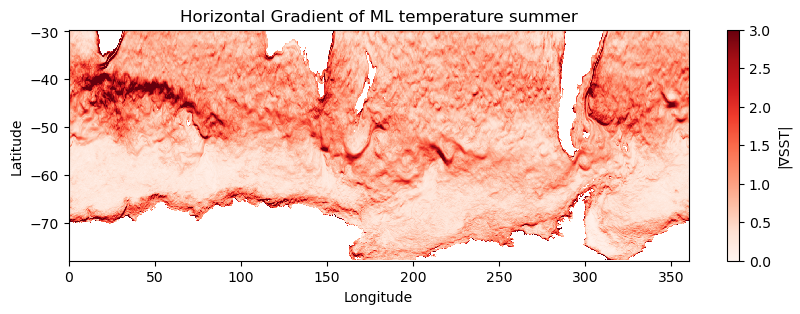

In [19]:
plt.figure()

time_str = pd.to_datetime(ds.time[ti].values).strftime('%B %Y')

var = grad_thetaML_summer

vmin = 0
vmax = 3
plt.pcolormesh(XCc, YCc, var, shading='auto', vmin=vmin, vmax=vmax, cmap='Reds')
plt.colorbar(label='|∇SST|')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Horizontal Gradient of ML temperature summer')

plt.show()

### Defining Atlantic sector

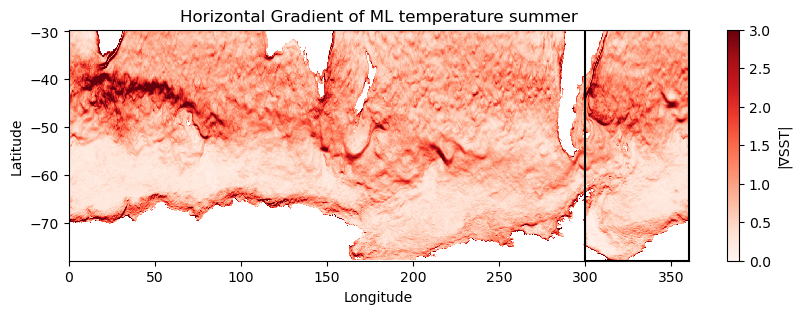

In [20]:
# Define box of Atlantic sector

box1_lon_min, box1_lon_max = 300, 360     
box1_lat_min, box1_lat_max = ds.YC[0], ds.YC[-1]

plt.figure()

time_str = pd.to_datetime(ds.time[ti].values).strftime('%B %Y')

var = grad_thetaML_summer

vmin = 0
vmax = 3
plt.pcolormesh(XCc, YCc, var, shading='auto', vmin=vmin, vmax=vmax, cmap='Reds')
plt.colorbar(label='|∇SST|')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Horizontal Gradient of ML temperature summer')

# Plot box1
plt.plot([box1_lon_min, box1_lon_max], [box1_lat_min, box1_lat_min], color='black')  # bottom
plt.plot([box1_lon_min, box1_lon_max], [box1_lat_max, box1_lat_max], color='black')  # top
plt.plot([box1_lon_min, box1_lon_min], [box1_lat_min, box1_lat_max], color='black')  # left
plt.plot([box1_lon_max, box1_lon_max], [box1_lat_min, box1_lat_max], color='black')  # right

### Meridional Temperature and salinity in the boxes

In [26]:
# Longitudinal avg in the box

mask = ds.maskC.sel(XC=slice(box1_lon_min, box1_lon_max),
    YC=slice(box1_lat_min, box1_lat_max)).mean(dim='XC')

theta_box1 = ds.THETA.sel(XC=slice(box1_lon_min, box1_lon_max),
    YC=slice(box1_lat_min, box1_lat_max)).mean(dim='XC')
theta_box1_masked = theta_box1.where(mask,np.nan)
theta_box1_clim = theta_box1_masked.groupby("time.month").mean("time")
month_names = [calendar.month_abbr[m] for m in theta_box1_clim["month"].values]
theta_box1_clim = theta_box1_clim.assign_coords(month=("month", month_names))
theta_box1_winter = theta_box1_clim.sel(month=["Jul", "Aug", "Sep"]).mean(dim='month')
theta_box1_summer = theta_box1_clim.sel(month=["Dec", "Jan", "Feb"]).mean(dim='month')

salt_box1 = salt_ds.SALT.sel(XC=slice(box1_lon_min, box1_lon_max),
    YC=slice(box1_lat_min, box1_lat_max)).mean(dim='XC')
salt_box1_masked = salt_box1.where(mask,np.nan)
salt_box1_clim = salt_box1_masked.groupby("time.month").mean("time")
month_names = [calendar.month_abbr[m] for m in salt_box1_clim["month"].values]
salt_box1_clim = salt_box1_clim.assign_coords(month=("month", month_names))
salt_box1_winter = salt_box1_clim.sel(month=["Jul", "Aug", "Sep"]).mean(dim='month')
salt_box1_summer = salt_box1_clim.sel(month=["Dec", "Jan", "Feb"]).mean(dim='month')

Text(0.5, 1.0, 'Winter Temperature')

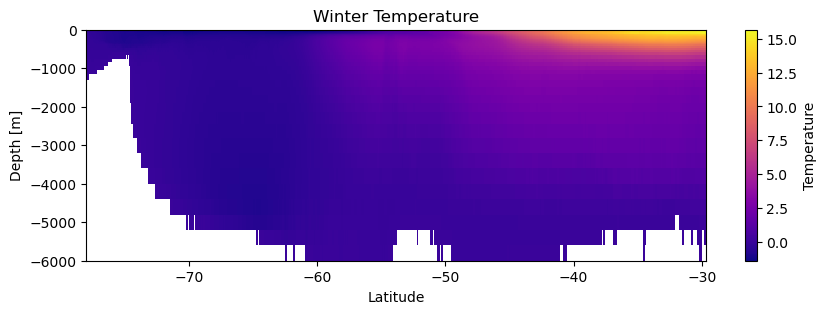

In [42]:
plt.figure()

var = theta_box1_winter

plt.pcolormesh(ds.YC, ds.Z, var, shading='auto', cmap='plasma')
plt.colorbar(label='Temperature')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title(f'Winter Temperature')

Text(0.5, 1.0, 'Winter Salinity')

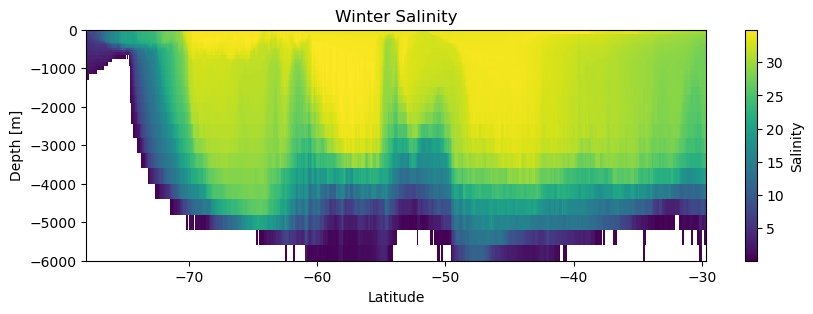

In [41]:
plt.figure()

var = salt_box1_winter

plt.pcolormesh(ds.YC, ds.Z, var, shading='auto', cmap='viridis')
plt.colorbar(label='Salinity')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title(f'Winter Salinity')

### DIC in the boxes

In [34]:
DIC = DIC_ds.TRAC01

In [35]:
DIC_box1 = DIC.sel(XC=slice(box1_lon_min, box1_lon_max),
    YC=slice(box1_lat_min, box1_lat_max)).mean(dim='XC')
DIC_box1_masked = DIC_box1.where(mask,np.nan)
DIC_box1_clim = DIC_box1_masked.groupby("time.month").mean("time")
month_names = [calendar.month_abbr[m] for m in DIC_box1_clim["month"].values]
DIC_box1_clim = DIC_box1_clim.assign_coords(month=("month", month_names))
DIC_box1_winter = DIC_box1_clim.sel(month=["Jul", "Aug", "Sep"]).mean(dim='month')
DIC_box1_summer = DIC_box1_clim.sel(month=["Dec", "Jan", "Feb"]).mean(dim='month')

<a list of 67 text.Text objects>

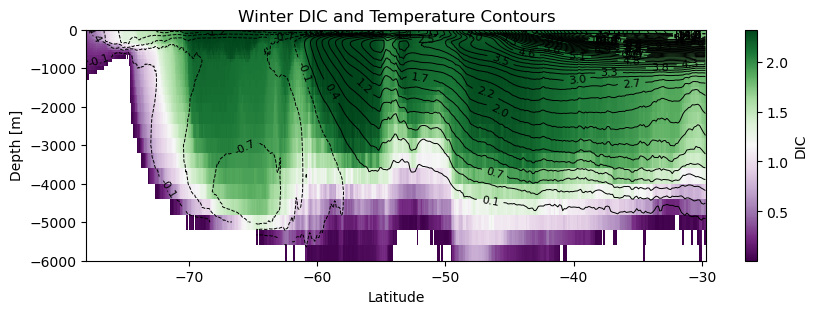

In [60]:
plt.figure()

var = DIC_box1_winter

plt.pcolormesh(ds.YC, ds.Z, var, shading='auto', cmap='PRGn')
plt.colorbar(label='DIC')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title(f'Winter DIC and Temperature Contours')

# Add contour lines
var = theta_box1_winter
vmin = -3
vmax = 15
contour_levels = np.linspace(vmin, vmax, 70)
cs = plt.contour(ds.YC, ds.Z, var, levels=contour_levels, colors='k', linewidths=0.7)
plt.clabel(cs, fmt="%.1f", fontsize=8)  # Optional: add labels to contours

<a list of 23 text.Text objects>

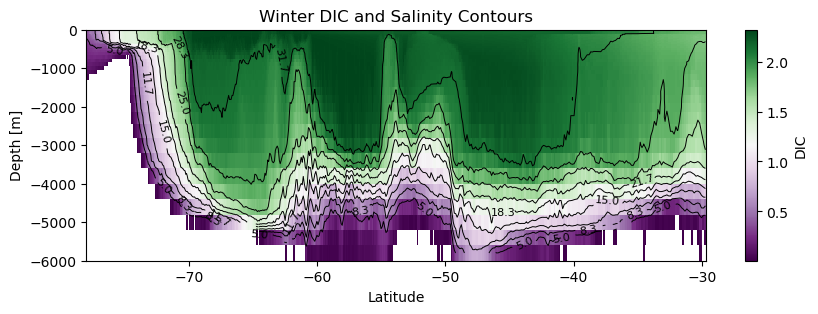

In [61]:
plt.figure()

var = DIC_box1_winter

plt.pcolormesh(ds.YC, ds.Z, var, shading='auto', cmap='PRGn')
plt.colorbar(label='DIC')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title(f'Winter DIC and Salinity Contours')

# Add contour lines
var = salt_box1_winter
vmin = 5
vmax = 35
contour_levels = np.linspace(vmin, vmax, 10)
cs = plt.contour(ds.YC, ds.Z, var, levels=contour_levels, colors='k', linewidths=0.7)
plt.clabel(cs, fmt="%.1f", fontsize=8)  # Optional: add labels to contours